In [28]:
import networkx as nx #import networkx package - allows us to graph netowrks 
import polars as pl #allows us to store and use dataframes
import matplotlib.pyplot as plt #imported this in order to utilize functions of plotting one or multiple networks
import numpy as np #use math functions for things like arrays 
import random #allows us to use random functions


In [29]:
#Import all the data 
df_1 = pl.read_csv("22140-0001-Data.tsv", separator="\t") 
df_2 = pl.read_csv("22140-0002-Data.tsv", separator="\t")
df_3 = pl.read_csv("22140-0003-Data.tsv", separator="\t")

In [30]:
df_1_clean = df_1.filter(
    (pl.col("SEX").is_in([0, 1])) &                   # keep only Male/Female
    (pl.col("RACE").is_in([1, 2, 3, 4, 5])) &         # valid race codes
    (pl.col("ETHN").is_in([0, 1])) &                  # valid ethnicity codes
    (pl.col("YOB").is_between(1900, 2000))            # plausible birth years
)

df_1_clean.select([ #boolean check to ensure filtering was successful
    (pl.col("SEX").is_in([0, 1]).all()).alias("valid_SEX"),
    (pl.col("RACE").is_in([1, 2, 3, 4, 5]).all()).alias("valid_RACE"),
    (pl.col("ETHN").is_in([0, 1]).all()).alias("valid_ETHN"),
    (pl.col("YOB").is_between(1900, 2025).all()).alias("valid_YOB")
])

num_nodes = df_1_clean.select(pl.col("RID")).n_unique()
print(f"Number of nodes (unique individuals) in filtered DS001 dataset: {num_nodes}")

Number of nodes (unique individuals) in filtered DS001 dataset: 14519


In [31]:
#combine the two studies using identifiers 
node_data = df_1.filter([pl.col("STUDYNUM")== 1]) 
edge_data = df_2.filter([pl.col("STUDYNUM")== 1])

#creating the basic contact network graph 
G = nx.Graph()
G.add_nodes_from(node_data["RID"])
G.nodes
G.add_edges_from(edge_data[["ID1", "ID2"]].rows())

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100]), array([6677, 6639, 6587, 6522, 6473, 6409, 6334, 6266, 6195, 6118, 6037,
       5955, 5874, 5788, 5706, 5623, 5529, 5451, 5352, 5273, 5200, 5119,
       5039, 4969, 4886, 4825, 4747, 4683, 4606, 4543, 4456, 4383, 4317,
       4256, 4186, 4108, 4054, 3996, 3919, 3860, 3783, 3730, 3663, 3597,
       3549, 3493, 3434, 3379, 3341, 3292, 3249, 3196, 3148, 3104, 3059,
       3010, 2963, 2919, 2866, 2821, 2777, 2729, 2678, 2631, 2583, 2550

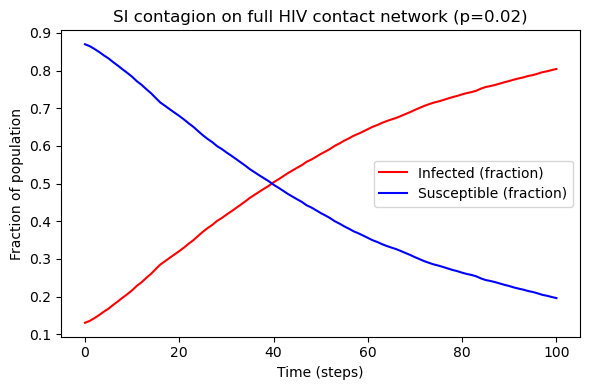

In [32]:
def SIContagion(G, initialInfected, p, tmin=0, tmax=100):
    """
    Parameters
    ----------
    G : NetworkX.Graph
    initialInfected : A set() of the nodes that are initially infected
    p : float between 0 and 1 that is the probability of infection
    tmin : integer of the initial time
    tmax : integer of the final time

    Returns
    -------
    t : numpy.array of the times
    S : numpy.array of the number of susceptible at each time
    I : numpy.array of the number of infected at each time
    """
    n = G.number_of_nodes()
    print
    infecteds = initialInfected.copy()
    newInfecteds = infecteds.copy()
    t = tmin
    times = [tmin]
    I = [len(infecteds)]
    S = [n - I[0]]

    while t < tmax:
        for node in G.nodes():
            if node not in infecteds:
                for nbr in G.neighbors(node):
                    if nbr in infecteds and random.random() <= p:
                        newInfecteds.add(node)
                        break
        t += 1
        infecteds = newInfecteds.copy()
        times.append(t)
        I.append(len(infecteds))
        S.append(n - I[-1])
    return np.array(times), np.array(S), np.array(I)
    
    
initialInfected = {i for i in random.sample(list(G.nodes), 1000)} #not sure how to choose initial infected
p = 0.02   #not sure how to choose p
print(SIContagion(G, initialInfected, p, tmin=0, tmax=100))

t, S, I = SIContagion(G, initialInfected, p, 0, 100)
print(f"Final infected fraction: {I[-1] / len(G):.3f}")

plt.figure(figsize=(6,4))
plt.plot(t, I / len(G), label="Infected (fraction)", color="red")
plt.plot(t, S / len(G), label="Susceptible (fraction)", color="blue")
plt.xlabel("Time (steps)")
plt.ylabel("Fraction of population")
plt.title(f"SI contagion on full HIV contact network (p={p})")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
yob_min = df_1.select(pl.col("YOB").min()).to_series()[0]
yob_max = df_1.select(pl.col("YOB").max()).to_series()[0]

print(f"Min YOB: {yob_min}, Max YOB: {yob_max}")

YOB = [[1900, 1910], [1911, 1920], [1921, 1930], [1931, 1940], [1941, 1950], [1951, 1960], [1961, 1970], [1971, 1980], [1981, 1990], [1991, 2000]]
"""
for yob_min, yob_max in YOB:
    df_1.filter((pl.col("YOB") >= 1900) & (pl.col("YOB") <= 1999))

sex_labels = {0: "Male", 1: "Female", -9: "OOD"}

for sex_code, label in sex_labels.items():
    subset = df_1.filter(pl.col("SEX") == sex_code)  #filtering based on sex and stored in subset 
    print(f"{label}: {subset.shape[0]} rows")
"""""
age_networks = {}

for i, (yob_min, yob_max) in enumerate(YOB):
    nodes = df_1.filter((pl.col("YOB") >= yob_min) & (pl.col("YOB") <= yob_max))
    G_yob = nx.Graph()
    G_yob.add_nodes_from(nodes["RID"])
    G_yob.add_edges_from(edge_data[["ID1", "ID2"]].rows())
    G_sub = G_yob.subgraph(nodes["RID"])

    age_networks[i] = G_sub


Min YOB: 1900, Max YOB: 1999


In [34]:
decade_labels = [
    "1900–1910", "1911–1920", "1921–1930", "1931–1940", "1941–1950",
    "1951–1960", "1961–1970", "1971–1980", "1981–1990", "1991–2000"
]
print(f"Decade {decade_labels[1]} has {nx.number_connected_components(age_networks[i])} components")

Decade 1911–1920 has 816 components


In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import networkx as nx

# --------------------------------------------------
# 1. Compute a single layout for the full network
# --------------------------------------------------
pos_full = nx.spring_layout(G, seed=42)  # reuse for all 3 plots


# --------------------------------------------------
# 2. Helper: color/shape full network by group
# --------------------------------------------------
def plot_full_network_by_group(
    G,
    group_nodes,
    pos,
    title,
    max_groups=12,
    node_size=20,
    group_colors=None,
    group_shapes=None,
):
    """
    G            : full NetworkX graph
    group_nodes  : dict[label -> set(node_ids)]
    pos          : dict of node positions (e.g. spring_layout(G))
    title        : plot title
    max_groups   : safety cap on number of groups
    node_size    : node size
    group_colors : optional dict[label -> color]
    group_shapes : optional dict[label -> marker ("o", "s", "^", "D", "P", "X", ...)]
    """

    # Keep only non-empty groups
    group_nodes = {lab: set(nodes) for lab, nodes in group_nodes.items() if len(nodes) > 0}

    labels = list(group_nodes.keys())[:max_groups]
    n_groups = len(labels)

    # If no custom colors, use tab10 colormap
    if group_colors is None:
        cmap = cm.get_cmap("tab10", n_groups)
        group_colors = {lab: cmap(i) for i, lab in enumerate(labels)}

    # If no custom shapes, default to circles
    if group_shapes is None:
        group_shapes = {lab: "o" for lab in labels}

    plt.figure(figsize=(8, 8))

    # Draw edges first (light gray)
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color="black",
        alpha=0.3,
        width=0.3,
    )

    # Draw each group separately so shapes work
    for lab in labels:
        nodes = list(group_nodes[lab])
        if not nodes:
            continue

        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=group_colors.get(lab, "black"),
            node_shape=group_shapes.get(lab, "o"),
            node_size=node_size,
            label=str(lab),
        )

    # Legend
    legend_elements = [
        Line2D(
            [0], [0],
            marker=group_shapes.get(lab, "o"),
            linestyle="None",
            color=group_colors.get(lab, "black"),
            label=str(lab),
            markersize=8,
        )
        for lab in labels
    ]

    plt.legend(
        handles=legend_elements,
        title="Group",
        loc="upper right",
        frameon=True,
    )
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [36]:
#create decades
from collections import defaultdict

nodes_in_G = set(G.nodes())
node_to_yob = {}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid in nodes_in_G:
        node_to_yob[rid] = int(row["YOB"])

decade_nodes = defaultdict(set)
for node, yob in node_to_yob.items():
    decade = (yob // 10) * 10
    decade_nodes[decade].add(node)


Decades and counts:
1900s: 28 nodes
1910s: 81 nodes
1920s: 157 nodes
1930s: 294 nodes
1940s: 807 nodes
1950s: 2475 nodes
1960s: 2571 nodes
1970s: 798 nodes
1980s: 331 nodes
1990s: 116 nodes
Simulating (seed in 1900s) with 28 candidate seed nodes...
Simulating (seed in 1910s) with 81 candidate seed nodes...
Simulating (seed in 1920s) with 157 candidate seed nodes...
Simulating (seed in 1930s) with 294 candidate seed nodes...
Simulating (seed in 1940s) with 807 candidate seed nodes...
Simulating (seed in 1950s) with 2475 candidate seed nodes...
Simulating (seed in 1960s) with 2571 candidate seed nodes...
Simulating (seed in 1970s) with 798 candidate seed nodes...
Simulating (seed in 1980s) with 331 candidate seed nodes...
Simulating (seed in 1990s) with 116 candidate seed nodes...


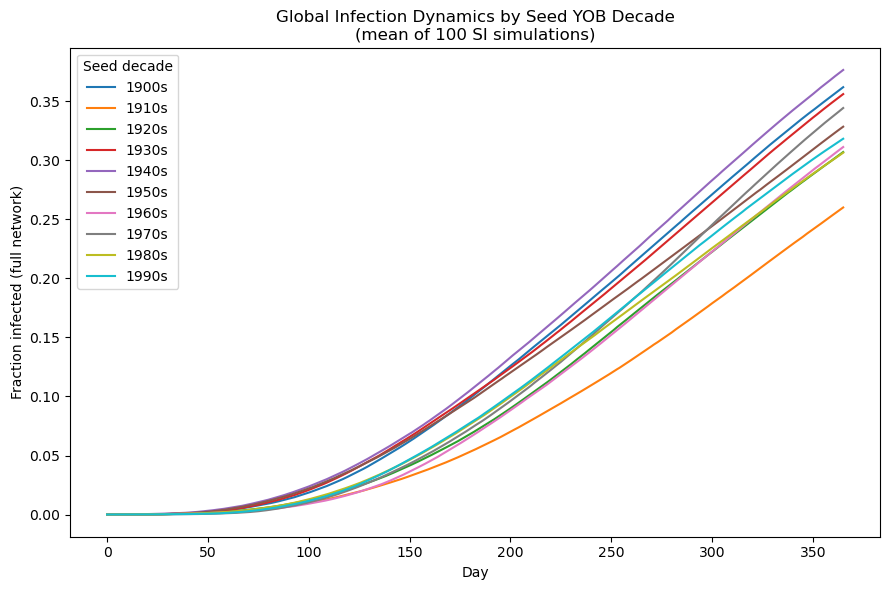

In [37]:
#RESULT 1 - DECADE/AGE BLOCKING 
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------------------------------------------------------------
# 1. Build decade_nodes from df_1_clean and G
# ---------------------------------------------------------------
nodes_in_G = set(G.nodes())
node_to_yob = {}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid in nodes_in_G:
        yob = int(row["YOB"])
        node_to_yob[rid] = yob

decade_nodes = defaultdict(set)
for node, yob in node_to_yob.items():
    decade = (yob // 10) * 10  # e.g. 1953 -> 1950
    decade_nodes[decade].add(node)

print("Decades and counts:")
for dec, nodes in sorted(decade_nodes.items()):
    print(f"{dec}s: {len(nodes)} nodes")


# ---------------------------------------------------------------
# 2. Fresh SI contagion function just for this experiment
#    (does NOT touch your original SIContagion_track)
# ---------------------------------------------------------------
def SIContagion_decade(G, initial_infected, p, tmax):
    """
    Simple SI model on an undirected graph.

    Parameters
    ----------
    G : networkx.Graph
    initial_infected : iterable of node ids
    p : float, per-contact infection probability per time step
    tmax : int, number of time steps

    Returns
    -------
    infected_over_time : list[set]
        infected_over_time[t] = set of infected nodes at time t
        (length = tmax + 1, including t=0).
    """
    infected = set(initial_infected)
    infected_over_time = [set(infected)]  # t = 0

    for _ in range(tmax):
        new_infected = set(infected)
        for u in infected:
            for v in G.neighbors(u):
                if v not in infected and random.random() < p:
                    new_infected.add(v)
        infected = new_infected
        infected_over_time.append(set(infected))

    return infected_over_time


# ---------------------------------------------------------------
# 3. Seed in a given decade, spread on FULL network,
#    measure global prevalence
# ---------------------------------------------------------------
def run_seed_decade_global(
    G,
    decade_nodes,
    p=0.01,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)
    mean_curves = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"Simulating (seed in {decade}s) with {len(nodes)} candidate seed nodes...")

        trajectories = []

        for _ in range(n_runs):
            # 1) pick a seed node inside this decade
            seed_node = random.choice(nodes)

            # 2) run SI on the *full* graph using our fresh SI function
            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed_node],
                p=p,
                tmax=tmax
            )

            # 3) global prevalence (fraction infected in entire network)
            frac_full = [
                len(infected) / N
                for infected in infected_over_time
            ]
            trajectories.append(frac_full)

        mean_curves[decade] = np.mean(np.array(trajectories), axis=0)

    return t_range, mean_curves


# ---------------------------------------------------------------
# 4. Run experiment + plot
# ---------------------------------------------------------------
t_range, mean_curves = run_seed_decade_global(
    G,
    decade_nodes,
    p=0.01,     # try 0.005–0.05 to see different dynamics
    tmax=365,
    n_runs=100
)

plt.figure(figsize=(9, 6))
for decade, curve in sorted(mean_curves.items()):
    plt.plot(t_range, curve, label=f"{decade}s")

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("Global Infection Dynamics by Seed YOB Decade\n(mean of 100 SI simulations)")
plt.legend(title="Seed decade")
plt.tight_layout()
plt.show()


[CI] Simulating (seed in 1900s) with 28 nodes...
[CI] Simulating (seed in 1910s) with 81 nodes...
[CI] Simulating (seed in 1920s) with 157 nodes...
[CI] Simulating (seed in 1930s) with 294 nodes...
[CI] Simulating (seed in 1940s) with 807 nodes...
[CI] Simulating (seed in 1950s) with 2475 nodes...
[CI] Simulating (seed in 1960s) with 2571 nodes...
[CI] Simulating (seed in 1970s) with 798 nodes...
[CI] Simulating (seed in 1980s) with 331 nodes...
[CI] Simulating (seed in 1990s) with 116 nodes...


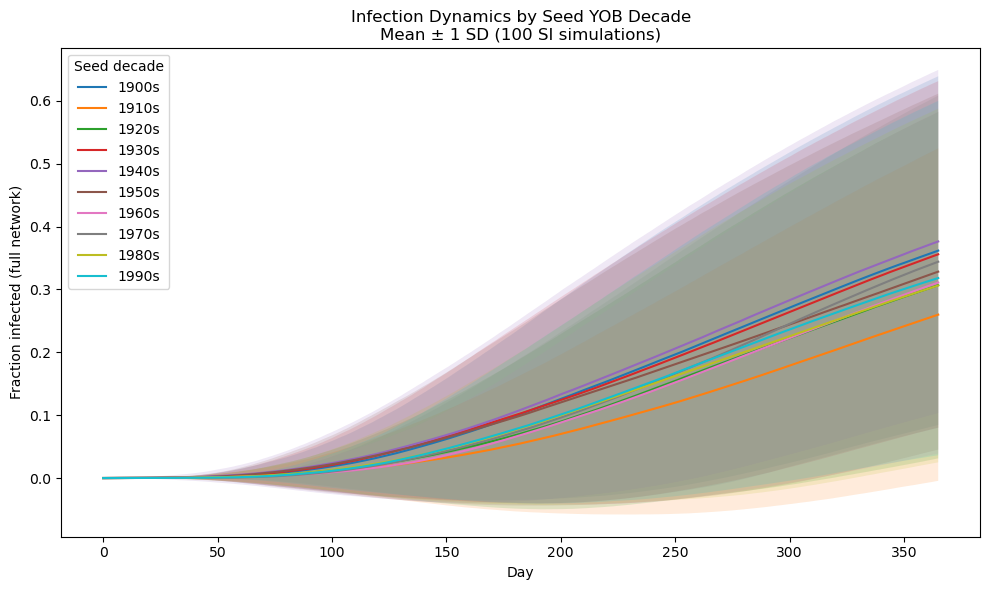

In [38]:
# ======================================================================
# CONFIDENCE BANDS FOR GLOBAL INFECTION DYNAMICS BY SEED DECADE
# ======================================================================

def run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.001, #HIV to Aids R_0 between 2% and 5%
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    decade_mean = {}
    decade_std = {}

    for decade, nodes in sorted(decade_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[CI] Simulating (seed in {decade}s) with {len(nodes)} nodes...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf)/N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)   # shape: (n_runs, tmax+1)

        decade_mean[decade] = arr.mean(axis=0)
        decade_std[decade] = arr.std(axis=0)

    return t_range, decade_mean, decade_std


# ---- RUN WITH CONFIDENCE BANDS ----
t_range, decade_mean, decade_std = run_seed_decade_with_CI(
    G,
    decade_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ---- PLOT WITH BANDS ----
plt.figure(figsize=(10, 6))

for decade in sorted(decade_mean.keys()):
    mean_curve = decade_mean[decade]
    sd_curve   = decade_std[decade]

    plt.plot(t_range, mean_curve, label=f"{decade}s")
    plt.fill_between(
        t_range,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("Infection Dynamics by Seed YOB Decade\nMean ± 1 SD (100 SI simulations)")
plt.legend(title="Seed decade")
plt.tight_layout()
plt.show()


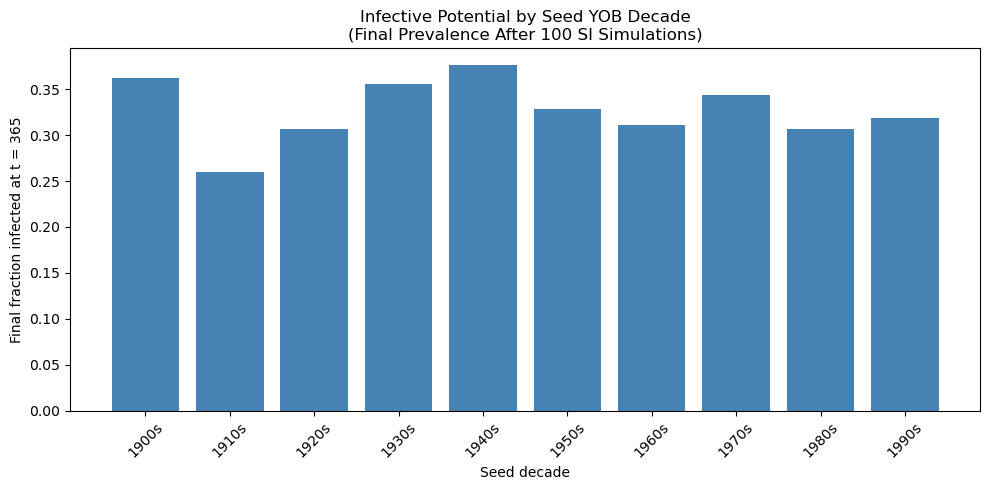

In [39]:
# ======================================================================
# BAR PLOT: INFECTIVE POTENTIAL BY SEED DECADE
# ======================================================================

final_values = {
    decade: decade_mean[decade][-1]   # last time point (t=365)
    for decade in decade_mean
}

# Sort by infective potential
sorted_decades = sorted(final_values.keys())
vals = [final_values[d] for d in sorted_decades]

plt.figure(figsize=(10, 5))
plt.bar([f"{d}s" for d in sorted_decades], vals, color="steelblue")
plt.xlabel("Seed decade")
plt.ylabel("Final fraction infected at t = 365")
plt.title("Infective Potential by Seed YOB Decade\n(Final Prevalence After 100 SI Simulations)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
import numpy as np
import random

def run_seed_group_with_CI(
    G,
    group_nodes,   # dict: label -> set(node_ids)
    p=0.01,
    tmax=365,
    n_runs=100,
    rng_seed=42
):
    """
    For each group label (e.g., decade, gender):
      - Seed infection in a node from that group
      - Run SI on the full graph G
      - Track fraction infected in the full network
      - Repeat n_runs times, return mean and std over runs
    """
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    N = G.number_of_nodes()
    t_range = np.arange(tmax + 1)

    group_mean = {}
    group_std  = {}

    for label, nodes in sorted(group_nodes.items()):
        nodes = list(nodes)
        if len(nodes) == 0:
            continue

        print(f"[CI] Simulating (seed in {label}) with {len(nodes)} seed candidates...")

        all_runs = []

        for _ in range(n_runs):
            seed = random.choice(nodes)

            infected_over_time = SIContagion_decade(
                G,
                initial_infected=[seed],
                p=p,
                tmax=tmax
            )

            frac = [len(inf) / N for inf in infected_over_time]
            all_runs.append(frac)

        arr = np.array(all_runs)  # shape: (n_runs, tmax+1)
        group_mean[label] = arr.mean(axis=0)
        group_std[label]  = arr.std(axis=0)

    return t_range, group_mean, group_std


In [41]:
# Build gender-based node groups from df_1_clean and G
# SEX: 0 = Male, 1 = Female
nodes_in_G = set(G.nodes())
gender_nodes = {"Male": set(), "Female": set()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in nodes_in_G:
        continue

    sex = row["SEX"]
    if sex == 0:
        gender_nodes["Male"].add(rid)
    elif sex == 1:
        gender_nodes["Female"].add(rid)

print("Gender groups and counts:")
for label, nodes in gender_nodes.items():
    print(label, len(nodes))


Gender groups and counts:
Male 5899
Female 4736


[CI] Simulating (seed in Female) with 4736 seed candidates...
[CI] Simulating (seed in Male) with 5899 seed candidates...


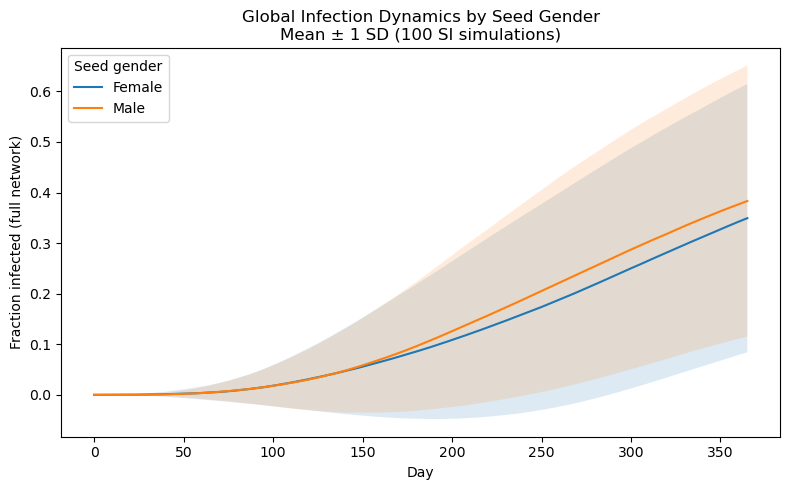

In [42]:
# Run SI with CI, but now by gender instead of decade
t_range_gender, gender_mean, gender_std = run_seed_group_with_CI(
    G,
    gender_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# Plot mean ± 1 SD curves by gender
plt.figure(figsize=(8, 5))

for label in sorted(gender_mean.keys()):
    mean_curve = gender_mean[label]
    sd_curve   = gender_std[label]

    plt.plot(t_range_gender, mean_curve, label=label)
    plt.fill_between(
        t_range_gender,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("Global Infection Dynamics by Seed Gender\nMean ± 1 SD (100 SI simulations)")
plt.legend(title="Seed gender")
plt.tight_layout()
plt.show()


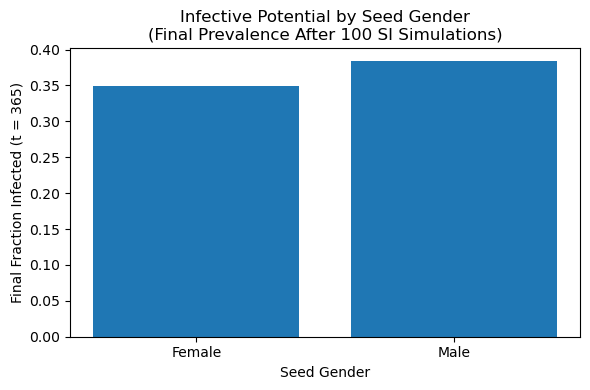

In [43]:
# =============================================
# Bar Plot: Infective Potential (Male vs Female)
# =============================================

# Extract final-day (t = 365) infection levels
gender_final = {
    label: gender_mean[label][-1]
    for label in gender_mean
}

labels = list(gender_final.keys())
values = [gender_final[label] for label in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel("Seed Gender")
plt.ylabel("Final Fraction Infected (t = 365)")
plt.title("Infective Potential by Seed Gender\n(Final Prevalence After 100 SI Simulations)")
plt.tight_layout()
plt.show()


Race groups and counts:
American Indian: 10 nodes
Black: 4559 nodes
Asian / Pacific Islander: 5470 nodes
White: 2442 nodes
Other: 56 nodes
[CI] Simulating (seed in American Indian) with 10 seed candidates...
[CI] Simulating (seed in Asian / Pacific Islander) with 5470 seed candidates...
[CI] Simulating (seed in Black) with 4559 seed candidates...
[CI] Simulating (seed in Other) with 56 seed candidates...
[CI] Simulating (seed in White) with 2442 seed candidates...


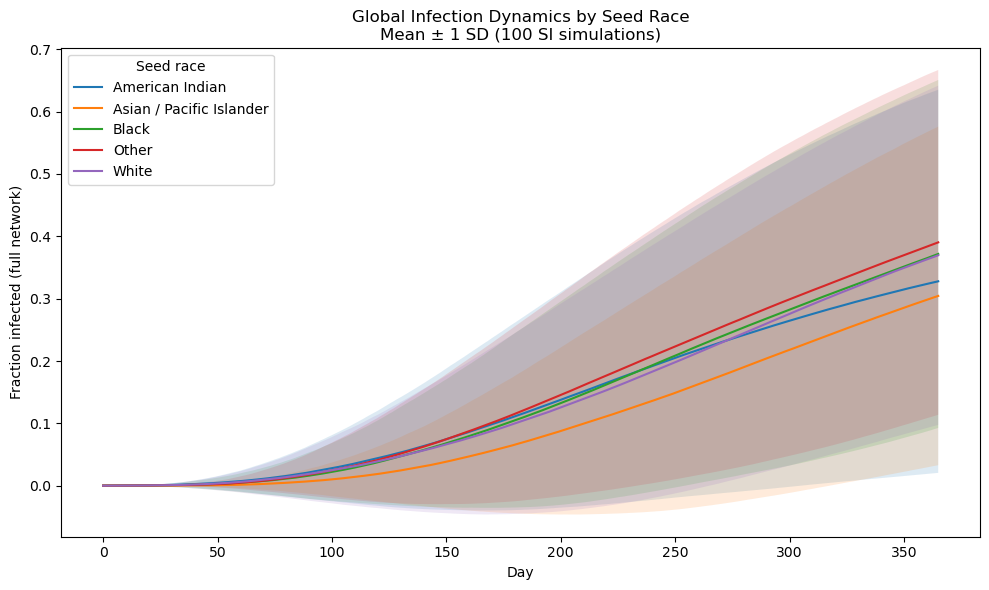

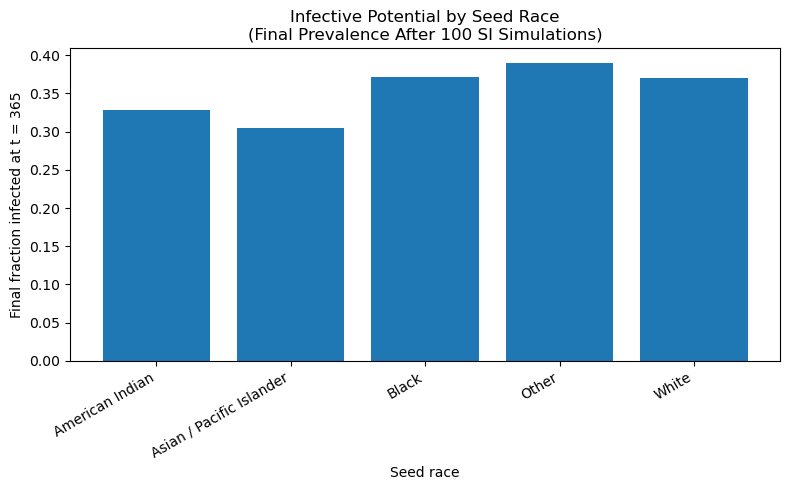

In [44]:
# ============================================
# 1. Build race-based groups (from codebook)
# ============================================
# Codebook for RACE:
# 1 = American Indian
# 2 = Black
# 3 = Asian / Pacific Islander
# 4 = White  (non-Black Hispanics already coded as White)
# 5 = Other
# -8, -9 etc. = missing / not asked / OOD

nodes_in_G = set(G.nodes())

race_code_to_label = {
    1: "American Indian",
    2: "Black",
    3: "Asian / Pacific Islander",
    4: "White",
    5: "Other"
}

# initialize group dict
race_nodes = {label: set() for label in race_code_to_label.values()}

for row in df_1_clean.iter_rows(named=True):
    rid = int(row["RID"])
    if rid not in nodes_in_G:
        continue

    race_code = row["RACE"]  # change to "race" if your column is lowercase
    label = race_code_to_label.get(race_code, None)
    if label is not None:
        race_nodes[label].add(rid)

print("Race groups and counts:")
for label, nodes in race_nodes.items():
    print(f"{label}: {len(nodes)} nodes")


# ============================================
# 2. Run SI with CI, seeded by race
# ============================================
t_range_race, race_mean, race_std = run_seed_group_with_CI(
    G,
    race_nodes,
    p=0.01,
    tmax=365,
    n_runs=100
)

# ============================================
# 3. Plot mean ± 1 SD curves by seed race
# ============================================
plt.figure(figsize=(10, 6))

for label in sorted(race_mean.keys()):
    mean_curve = race_mean[label]
    sd_curve   = race_std[label]

    plt.plot(t_range_race, mean_curve, label=label)
    plt.fill_between(
        t_range_race,
        mean_curve - sd_curve,
        mean_curve + sd_curve,
        alpha=0.15
    )

plt.xlabel("Day")
plt.ylabel("Fraction infected (full network)")
plt.title("Global Infection Dynamics by Seed Race\nMean ± 1 SD (100 SI simulations)")
plt.legend(title="Seed race")
plt.tight_layout()
plt.show()


# ============================================
# 4. Bar plot: infective potential by race
# ============================================
race_final = {
    label: race_mean[label][-1]   # final-day prevalence
    for label in race_mean
}

labels = list(race_final.keys())
values = [race_final[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel("Seed race")
plt.ylabel("Final fraction infected at t = 365")
plt.title("Infective Potential by Seed Race\n(Final Prevalence After 100 SI Simulations)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


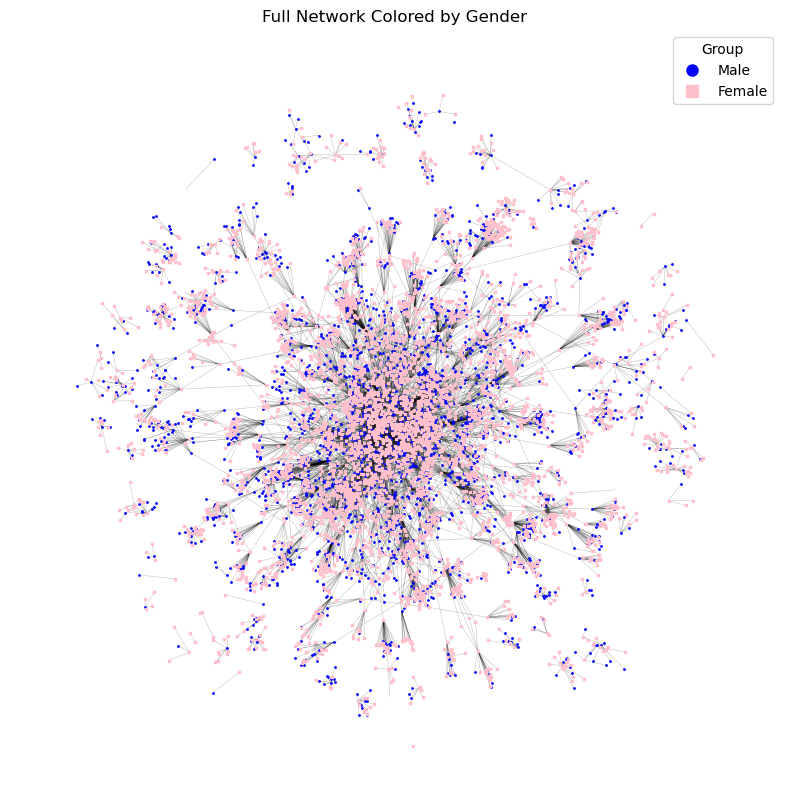

In [45]:
custom_colors_gender = {
    "Male": "blue",
    "Female": "pink",
}

custom_shapes_gender = {
    "Male": "o",   # circle
    "Female": "s", # square
}

plot_full_network_by_group(
    G,
    gender_nodes,
    pos_full,
    title="Full Network Colored by Gender",
    node_size=1,
    group_colors=custom_colors_gender,
    group_shapes=custom_shapes_gender,
)


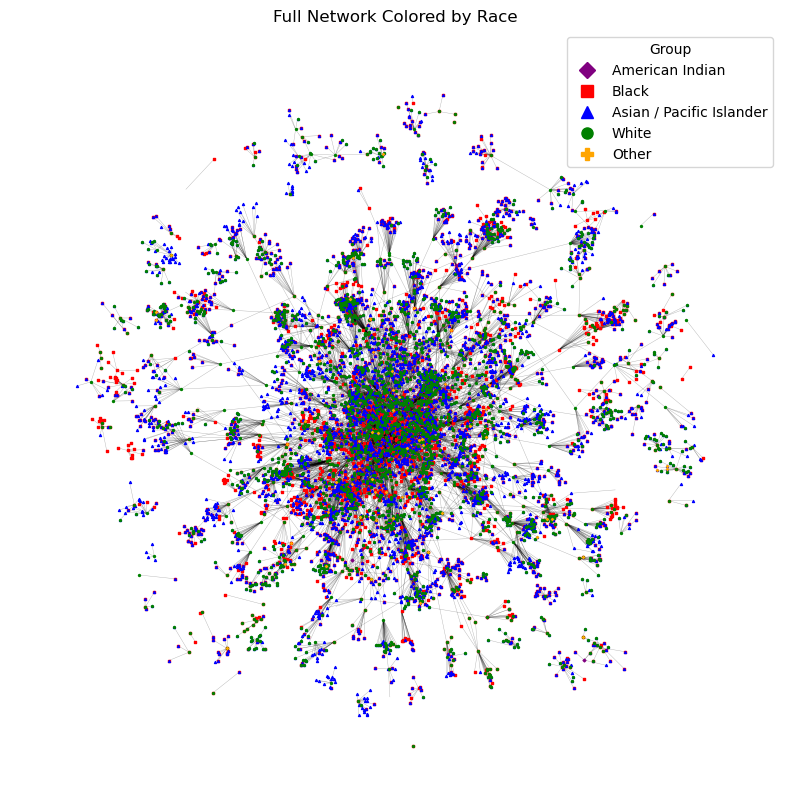

In [46]:
custom_colors_race = {
    "White": "green",
    "Black": "red",
    "Asian / Pacific Islander": "blue",
    "American Indian": "purple",
    "Other": "orange",
}

custom_shapes_race = {
    "White": "o",
    "Black": "s",
    "Asian / Pacific Islander": "^",
    "American Indian": "D",
    "Other": "P",
}

plot_full_network_by_group(
    G,
    race_nodes,
    pos_full,
    title="Full Network Colored by Race",
    node_size=2,
    group_colors=custom_colors_race,
    group_shapes=custom_shapes_race,
)


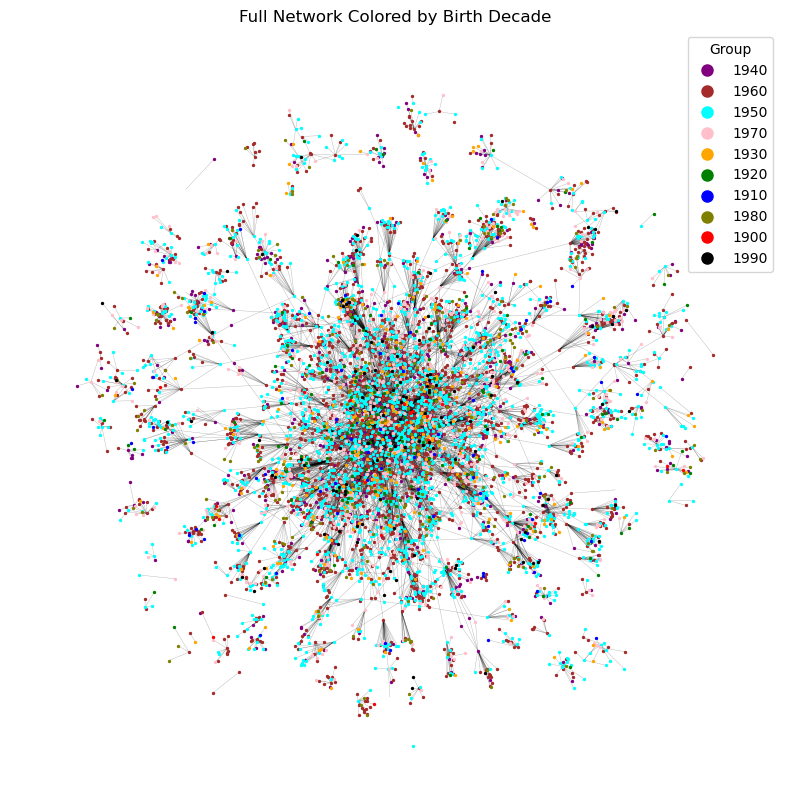

In [47]:
# ============================================
# CUSTOM COLORS + SHAPES FOR DECADES
# ============================================

# Good 10-color palette for your decades:
custom_colors_decades = {
    1900: "red",
    1910: "blue",
    1920: "green",
    1930: "orange",
    1940: "purple",
    1950: "cyan",
    1960: "brown",
    1970: "pink",
    1980: "olive",
    1990: "black",
}

# All same shape (circles)
custom_shapes_decades = {dec: "o" for dec in custom_colors_decades}


# ============================================
# PLOT FULL NETWORK COLORED BY DECADE
# ============================================

plot_full_network_by_group(
    G,
    decade_nodes,
    pos_full,
    title="Full Network Colored by Birth Decade",
    node_size=2,
    group_colors=custom_colors_decades,
    group_shapes=custom_shapes_decades,
)
